# Perfs

## Import de la recherche

In [1]:
from typing import Callable, List, Dict
from index import Document, Corpus, InvertedIndex, Query

import pandas, os, re

DATA_FOLDER = os.path.join(os.getcwd(), "output")

XML_INITIAL_FILE = os.path.join(DATA_FOLDER, "corpus_initial.xml")
STEMMED_REPLACEMENTS = os.path.join(DATA_FOLDER, "stemmed_replacement.tsv")
LEMMATIZED_REPLACEMENTS = os.path.join(DATA_FOLDER, "lemmatized_replacement.tsv")

TEXTE_INDEX_FILE = os.path.join(DATA_FOLDER, "index_files", "texte_index.xml")
LEGENDE_INDEX_FILE = os.path.join(DATA_FOLDER, "index_files", "legende_index.xml")
TITRE_INDEX_FILE = os.path.join(DATA_FOLDER, "index_files", "titre_index.xml")

STORAGE_TAGS = {"Corpus": "corpus", "documents": "bulletins", "Document": "bulletin", "Image": "image"}

STANDARDIZE: Callable[[str], str] = lambda x: re.sub(r"[^\w\s]", "", re.sub(r"'", " ", x.strip().lower()))

In [2]:
# 1. Charge le Corpus
with open(XML_INITIAL_FILE, "r", encoding="utf-8") as f:
    CORPUS = Corpus.model_validate_xml(f.read(), tags=STORAGE_TAGS)

# 2. Charge l'Index inversé par zone    
INDEX: Dict[str, InvertedIndex] = {}
for zone, file in zip(["texte", "legendes", "titre"], [TEXTE_INDEX_FILE, LEGENDE_INDEX_FILE, TITRE_INDEX_FILE]):
    INDEX[zone] = InvertedIndex.from_dataframe(pandas.read_csv(file, sep="\t", encoding="utf-8"))
    
# 3. Charge le dictionnaire de lemmatisation
substitutions_df = pandas.read_csv(STEMMED_REPLACEMENTS, sep="\t", header=None, na_filter=False)
substitutions = {inp: repl for inp, repl in zip(substitutions_df.iloc[:,0], substitutions_df.iloc[:,1])}
TOKENIZE: Callable[[List[str]], List[str]] = lambda x: [substitutions.get(STANDARDIZE(token), STANDARDIZE(token)) for token in x]

# 4. Défini la search function (et l'application de la lemmatisation)
def search(s: str) -> List[Document]:
    q = Query.build(
        'montre moi les articles qui parlent de environnement minimum depuis juillet 2011 et qui nest pas dans la rubrique Focus',
    )
    for field in ["keywords", "excluded_keywords", "title_contains"]:
        setattr(q, field, TOKENIZE(getattr(q, field)))
    for field in ["rubriques", "excluded_rubriques"]:
        setattr(q, field, [STANDARDIZE(r) for r in getattr(q, field)])
    return q.search(documents=CORPUS, index=INDEX)

C:\Users\ongki\AppData\Local\Temp\ipykernel_19988\1112978524.py:8: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,25

## Evaluation des Performances

In [5]:
TRUTH: Dict[str, List[Document]] = {
    "this is a set of queries": ["123"],
    "mapped to the documents that": ["456"],
    "should be retrieved": ["123", "456"],
} # TODO : Récupérer les exemples de recherche de Raphael

### Fonctions statistiques

In [15]:
search_function: Callable[[str], List[str]] = lambda x: [d.document_id for d in search(x)]

### Calcul des métriques

In [ ]:
import pandas, datetime

DATA: Dict[str, pandas.DataFrame] = {name: pandas.DataFrame(columns=["Recall", "Precision", "Delay", "Hint"]) for name in ["spacy", "stem"]}

for layer, stat in zip(["spacy", "stem"], [search_function, search_function]):

    for query, truth in TRUTH.items():
        
        start = datetime.datetime.now()
        results = stat(query)

        row = {
            "Recall":    len(set(results) & set(truth)) / len(truth),
            "Precision": len(set(results) & set(truth)) / len(results) if len(results) > 0 else 0.0,
            "Size":      len(results),
            "Delay":     (datetime.datetime.now() - start).total_seconds(),
            "Hint":      query,
        }

        DATA[layer] = pandas.concat([DATA[layer], pandas.DataFrame([row])], ignore_index=True)

DATA["spacy"]

C:\Users\ongki\AppData\Local\Temp\ipykernel_19988\2302032615.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  DATA[layer] = pandas.concat([DATA[layer], pandas.DataFrame([row])], ignore_index=True)


,Recall,Precision,Delay,Hint
0,0.0,0.0,2.557749,this is a set of queries
1,0.0,0.0,2.464743,mapped to the documents that
2,0.0,0.0,2.612612,should be retrieved


In [19]:
DATA["stem"]

,Recall,Precision,Delay,Hint
0,0.0,0.0,2.301745,this is a set of queries
1,0.0,0.0,2.507622,mapped to the documents that
2,0.0,0.0,2.678724,should be retrieved


### Visualisation

In [20]:
df = DATA["spacy"].melt(
    value_vars=["Recall","Precision","Delay"],
    var_name="Metric",
    value_name="Score"
)
df.head(2)

,Metric,Score
0,Recall,0.0
1,Recall,0.0


<Axes: ylabel='Delay'>

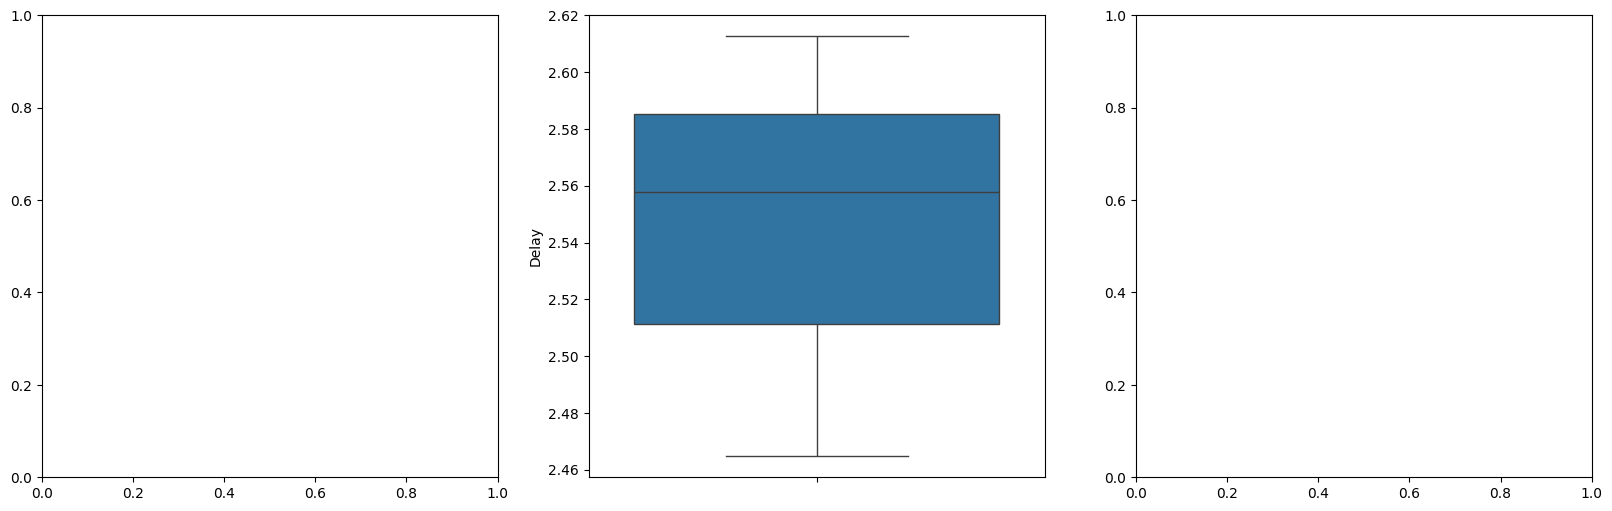

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Boxplots of the metrics
sns.boxplot(y="Delay", data=DATA["spacy"], ax=axs[1])

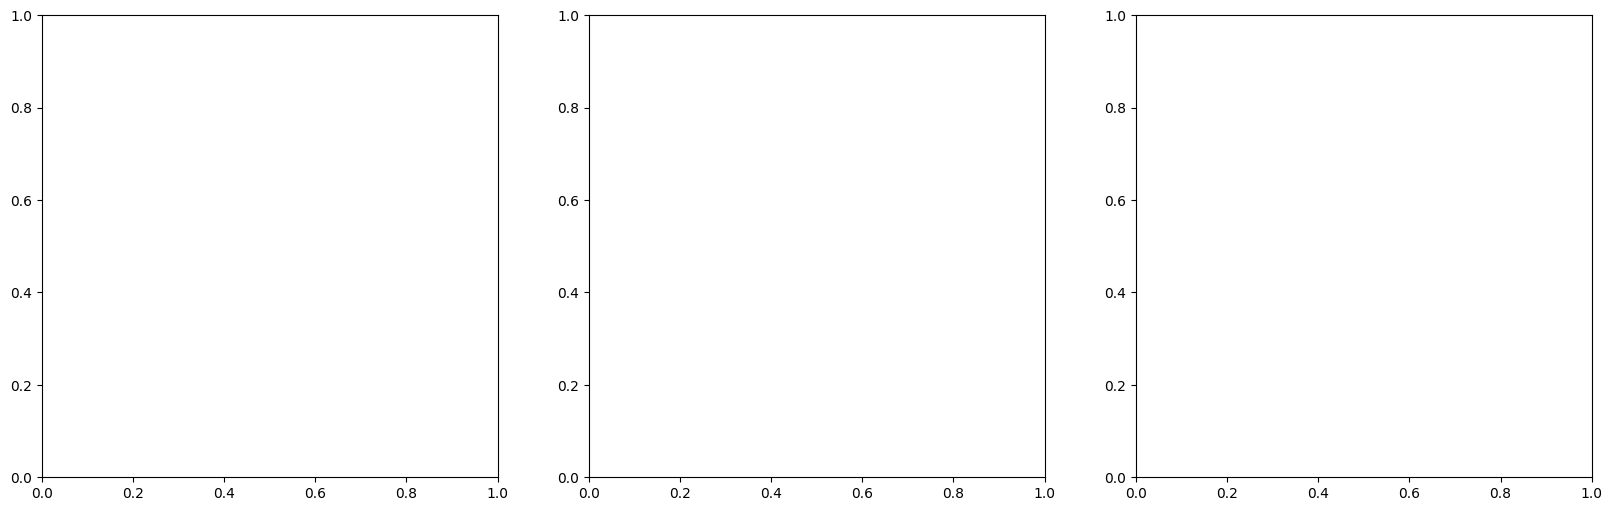

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Plot using complexity / length of the query (nuage de points qui forme une espèce de courbe)

# Plot with lemmatizer or with stemmer (have to change the recording function) (deux boxplots)

# Plot with extra tokenization and without extra tokenization (reposer sur le corpus ou plus)
